In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.special import rel_entr
from itertools import chain, combinations
from collections import defaultdict, Counter
import random
import pickle

In [ ]:
# Define the base folder path to your project directory in Google Drive
Ds_project_folder_path = '/content/drive/MyDrive/DS_project/'

# Folder where raw input data is stored
raw_data_path = 'Data/1_raw_data/'

# Folder where processed output data will be saved
gene_name_mapping_data_path = 'Data/2_gene_name_mapping_data/'

clinical_data_path = 'Data/0.clinical_rdata_to_csv/'

filtered_by_plate_rna_seq_data_path = 'Data/3_RNA_seq_sample_filtering_by_plate/'

data_clearning_path = 'Data/4_Intra-cohort-preprocessing/4.1.Data_clearning/'

data_spliting_path = 'Data/5_Inter-cohort_preprocessing/5.1.data_spliting/'

In [ ]:
GBM_Data_clearing_result_file_name = 'GBM_omics_samples_MOFA.pickle'
LGG_Data_clearing_result_file_name = 'LGG_omics_samples_MOFA.pickle'

In [ ]:
GBM_data_split_result_name = 'GBM_data_split_result.pickle'
LGG_data_split_result_name = 'LGG_data_split_result.pickle'

In [ ]:
# Whether to use gene-mapped data (True) or raw probe-based data (False)

gene_mapping = False

**Data Loading**

In [ ]:
def RNA_seq_and_CNV_data_load(gene_mapping = True):
  RNA_seq_path = Ds_project_folder_path + filtered_by_plate_rna_seq_data_path

  if gene_mapping:
    CNV_path = Ds_project_folder_path + gene_name_mapping_data_path
    GBM_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-GBM_mRNA_gene_map_filtered_by_plate.csv', index_col=0)
    LGG_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-LGG_mRNA_gene_map_filtered_by_plate.csv', index_col=0)

    GBM_CNV_data = pd.read_csv(CNV_path + 'TCGA-GBM_CNV_gene_mapping.csv', index_col=0)
    LGG_CNV_data = pd.read_csv(CNV_path + 'TCGA-LGG_CNV_gene_mapping.csv', index_col=0)

  else:
    CNV_path = Ds_project_folder_path + raw_data_path

    GBM_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-GBM_mRNA_filtered_by_plate.csv', index_col=0)
    LGG_rna_seq_data = pd.read_csv(RNA_seq_path + 'TCGA-LGG_mRNA_filtered_by_plate.csv', index_col=0)

    GBM_CNV_data = pd.read_csv(RNA_seq_path + 'TCGA-GBM_CNV_filtered_chromosome.csv', index_col=0)
    LGG_CNV_data = pd.read_csv(RNA_seq_path + 'TCGA-LGG_CNV_filtered_chromosome.csv', index_col=0)

  return GBM_rna_seq_data, LGG_rna_seq_data, GBM_CNV_data, LGG_CNV_data

In [ ]:
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_GBM_SNV.tsv.gz', 'rt') as f:
    GBM_SNV_data = pd.read_csv(f, sep='\t')
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_LGG_SNV.tsv.gz', 'rt') as f:
    LGG_SNV_data = pd.read_csv(f, sep='\t')

with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA-GBM.protein.tsv.gz', 'rt') as f:
    GBM_protein_data = pd.read_csv(f, sep='\t')
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA-LGG.protein.tsv.gz', 'rt') as f:
    LGG_protein_data = pd.read_csv(f, sep='\t')

with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_GBM_mval_methylation.tsv.gz', 'rt') as f:
    GBM_methlylation_data = pd.read_csv(f, sep='\t')
with gzip.open(Ds_project_folder_path + raw_data_path + 'TCGA_LGG_mval_methylation.tsv.gz', 'rt') as f:
    LGG_methlylation_data = pd.read_csv(f, sep='\t')

GBM_rna_seq_data, LGG_rna_seq_data, GBM_CNV_data, LGG_CNV_data = RNA_seq_and_CNV_data_load(gene_mapping)

In [ ]:
with open(Ds_project_folder_path + data_clearning_path + GBM_Data_clearing_result_file_name, 'rb') as f:
    filtered_GBM_omics = pickle.load(f)
with open(Ds_project_folder_path + data_clearning_path + LGG_Data_clearing_result_file_name, 'rb') as f:
    filtered_LGG_omics = pickle.load(f)

**External dataset**

In [ ]:
GBM_filtered_sample = list(set([ sample for _, samples in filtered_GBM_omics.items() for sample in samples]))
LGG_filtered_sample = list(set([ sample for _, samples in filtered_LGG_omics.items() for sample in samples]))

In [ ]:
GMB_center_list = list(set([i.split('-')[1] for i in GBM_filtered_sample]))
LGG_center_list = list(set([i.split('-')[1] for i in LGG_filtered_sample]))
GMB_center_list.sort()
LGG_center_list.sort()

In [ ]:
GMB_center_tss_sample ={i:[] for i in GMB_center_list}
LGG_center_tss_sample ={i:[] for i in LGG_center_list}

In [ ]:
for i in GBM_filtered_sample:
  GMB_center_tss_sample[i.split('-')[1]].append(i)
for i in LGG_filtered_sample:
  LGG_center_tss_sample[i.split('-')[1]].append(i)

In [ ]:
print('centers of GBM:',GMB_center_tss_sample.keys())
print('centers of LGG',LGG_center_tss_sample.keys())

centers of GBM: dict_keys(['02', '06', '08', '12', '14', '15', '16', '19', '26', '27', '28', '32', '41', '4W', '74', '76', '81', '87', 'OX', 'RR'])
centers of LGG dict_keys(['CS', 'DB', 'DH', 'DU', 'E1', 'EZ', 'F6', 'FG', 'FN', 'HT', 'HW', 'IK', 'KT', 'P5', 'QH', 'R8', 'RY', 'S9', 'TM', 'TQ', 'VM', 'VV', 'VW', 'W9', 'WH', 'WY'])


In [ ]:
GMB_center_tss_sample_ratio = pd.DataFrame({
    'TSS': list(GMB_center_tss_sample.keys()),
    'Sample Ratio': [len(v)/len(GBM_filtered_sample) for v in GMB_center_tss_sample.values()]
})

LGG_center_tss_sample_ratio = pd.DataFrame({
    'TSS': list(LGG_center_tss_sample.keys()),
    'Sample Ratio': [len(v)/len(LGG_filtered_sample) for v in LGG_center_tss_sample.values()]
})

Text(0, 0.5, 'Sample Ratio')

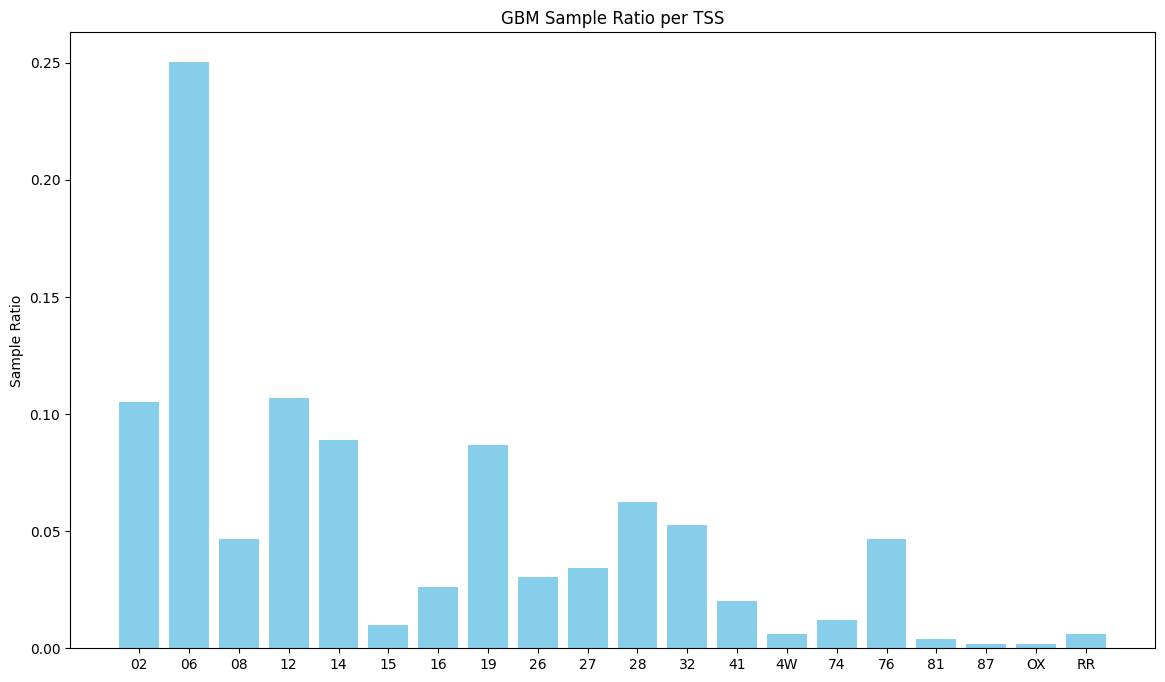

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(14, 8), sharex=True)

axs.bar(GMB_center_tss_sample_ratio['TSS'], GMB_center_tss_sample_ratio['Sample Ratio'], color='skyblue')
axs.set_title('GBM Sample Ratio per TSS')
axs.set_ylabel('Sample Ratio')

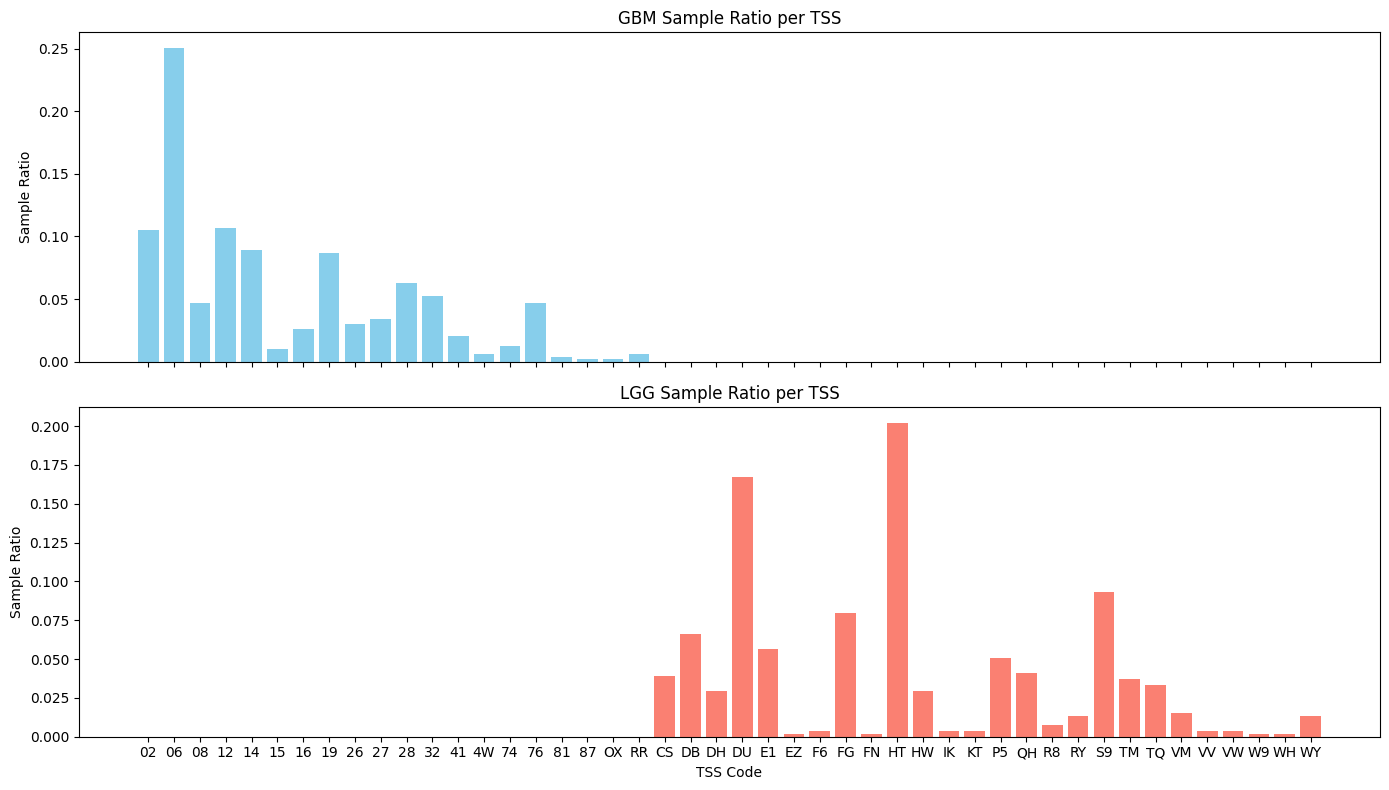

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axs[0].bar(GMB_center_tss_sample_ratio['TSS'], GMB_center_tss_sample_ratio['Sample Ratio'], color='skyblue')
axs[0].set_title('GBM Sample Ratio per TSS')
axs[0].set_ylabel('Sample Ratio')

axs[1].bar(LGG_center_tss_sample_ratio['TSS'], LGG_center_tss_sample_ratio['Sample Ratio'], color='salmon')
axs[1].set_title('LGG Sample Ratio per TSS')
axs[1].set_xlabel('TSS Code')
axs[1].set_ylabel('Sample Ratio')

plt.tight_layout()
plt.show()

In [ ]:
def kl_divergence(p, q, eps=1e-8):
    """
    Compute Kullback-Leibler divergence D_KL(P || Q)
    between two probability distributions p and q.
    """
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return np.sum(rel_entr(p, q))

def build_omics_combinations_with_samples(omics_dict):
    """
    Given a dictionary {omics_layer: list of sample IDs},
    returns a DataFrame with columns:
        'Omics Combination' : a string representing the combination of omics (e.g., 'RNAseq+SNV'),
        'Sample IDs'        : list of sample IDs that share that omics combination.
    """
    sample_to_omics = defaultdict(set)

    # Step 1: Create a mapping from each sample to the set of omics it has
    for omics, samples in omics_dict.items():
        for sample in samples:
            sample_to_omics[sample].add(omics)

    # Step 2: Normalize the omics combination to a sorted string label
    sample_to_combo = {
        sample: '+'.join(sorted(omics_set))
        for sample, omics_set in sample_to_omics.items()
    }

    # Step 3: Invert the mapping to get: {omics_combination: list of sample IDs}
    combo_to_samples = defaultdict(list)
    for sample, combo in sample_to_combo.items():
        combo_to_samples[combo].append(sample)

    # Step 4: Create a DataFrame
    df = pd.DataFrame({
        'Omics Combination': list(combo_to_samples.keys()),
        'Sample IDs': list(combo_to_samples.values())
    })

    return df

In [ ]:
def find_center_split_fixed_sample_ratio_with_tolerance(
    omics_dict,
    center_to_samples,
    omics_combinations_df,
    target_ratio=0.2,
    tolerance=0.05,
    num_trials=1000,
    seed=42
):
    """
    Split centers into train/test such that:
    1. The test set sample count is within a given tolerance of the target ratio,
    2. The omics combination distribution in the test set is as close as possible
       to the full distribution (measured via KL divergence).

    Parameters:
        omics_dict (dict): {omics_layer: set of sample IDs}
        center_to_samples (dict): {center: list of sample IDs}
        omics_combinations_df (DataFrame): contains 'Omics Combination'
        target_ratio (float): desired test sample ratio (e.g., 0.3 for 30%)
        tolerance (float): allowed deviation from target_ratio (e.g., 0.05)
        num_trials (int): number of random attempts
        seed (int): random seed

    Returns:
        best_train_centers (list)
        best_test_centers (list)
        best_kl_score (float)
    """
    random.seed(seed)
    np.random.seed(seed)

    # 1. Map samples to omics combination
    sample_to_omics = defaultdict(set)
    for omics, samples in omics_dict.items():
        for sample in samples:
            sample_to_omics[sample].add(omics)

    sample_to_combo = {
        sample: '+'.join(sorted(omics_set))
        for sample, omics_set in sample_to_omics.items()
    }

    # 2. Global omics combination distribution
    all_combos = omics_combinations_df['Omics Combination'].tolist()
    total_counts = Counter(sample_to_combo.values())
    total_vector = np.array([total_counts[c] for c in all_combos], dtype=np.float32)
    total_vector /= total_vector.sum()

    # 3. Sample count per center
    all_centers = list(center_to_samples.keys())
    center_sample_counts = {c: len(center_to_samples[c]) for c in all_centers}
    total_samples = sum(center_sample_counts.values())
    target_test_samples = int(round(total_samples * target_ratio))
    min_samples = int(total_samples * (target_ratio - tolerance))
    max_samples = int(total_samples * (target_ratio + tolerance))

    best_score = float('inf')
    best_train = best_test = None

    # 4. Search for the best split
    for _ in range(num_trials):
        random.shuffle(all_centers)
        current_test = []
        current_test_count = 0

        for c in all_centers:
            current_test.append(c)
            current_test_count += center_sample_counts[c]
            if current_test_count >= max_samples:
                break

        # Only accept splits within target ± tolerance
        if not (min_samples <= current_test_count <= max_samples):
            continue

        current_train = [c for c in all_centers if c not in current_test]

        test_samples = {
            s for c in current_test
            for s in center_to_samples.get(c, [])
            if s in sample_to_combo
        }

        test_counts = Counter([sample_to_combo[s] for s in test_samples])
        test_vector = np.array([test_counts[c] for c in all_combos], dtype=np.float32)

        if test_vector.sum() == 0:
            continue

        test_vector /= test_vector.sum()
        score = kl_divergence(total_vector, test_vector)

        if score < best_score:
            best_score = score
            best_train = current_train
            best_test = current_test

    return best_train, best_test, best_score

In [ ]:
def plot_train_test_distribution_by_omics_combo(
    train_centers,
    test_centers,
    omics_dict,
    center_to_samples,
    omics_combinations_df
):
    """
    Plot the distribution of omics combinations across total, train, and test sets.

    Parameters:
        train_centers (list): center names in training set
        test_centers (list): center names in test set
        omics_dict (dict): {omics_layer: set of sample IDs}
        center_to_samples (dict): {center: list of sample IDs}
        omics_combinations_df (DataFrame): must contain 'Omics Combination' column

    Returns:
        DataFrame: ratios of each omics combination in total, train, and test sets
    """
    # Map sample to omics combo
    sample_to_omics = defaultdict(set)
    for omics, samples in omics_dict.items():
        for sample in samples:
            sample_to_omics[sample].add(omics)

    sample_to_combo = {
        sample: '+'.join(sorted(omics_set))
        for sample, omics_set in sample_to_omics.items()
    }

    all_samples = set(sample_to_combo.keys())
    train_samples = {
        s for c in train_centers
        for s in center_to_samples.get(c, [])
        if s in sample_to_combo
    }
    test_samples = {
        s for c in test_centers
        for s in center_to_samples.get(c, [])
        if s in sample_to_combo
    }

    combo_list = omics_combinations_df['Omics Combination'].tolist()

    def get_ratio_vector(samples):
        counter = Counter([sample_to_combo[s] for s in samples])
        vec = np.array([counter[c] for c in combo_list], dtype=np.float32)
        return vec / vec.sum()

    total_ratio = get_ratio_vector(all_samples)
    train_ratio = get_ratio_vector(train_samples)
    test_ratio = get_ratio_vector(test_samples)

    # Plotting
    x = np.arange(len(combo_list))
    width = 0.25

    plt.figure(figsize=(14, 6))
    plt.bar(x - width, total_ratio, width, label='Total')
    plt.bar(x, train_ratio, width, label='Train')
    plt.bar(x + width, test_ratio, width, label='Test')

    plt.xticks(x, combo_list, rotation=45, ha='right')
    plt.ylabel("Proportion of Samples")
    plt.title("Omics Combination Distribution: Total vs Train vs Test")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        'Omics Combination': combo_list,
        'Total': total_ratio,
        'Train': train_ratio,
        'Test': test_ratio
    })

In [ ]:
def plot_train_test_stacked_counts_by_omics_combo(
    train_centers,
    test_centers,
    omics_dict,
    center_to_samples,
    omics_combinations_df
):
    """
    Plot stacked bar chart of train/test counts per omics combination.

    Parameters:
        train_centers (list): center names in training set
        test_centers (list): center names in test set
        omics_dict (dict): {omics_layer: set of sample IDs}
        center_to_samples (dict): {center: list of sample IDs}
        omics_combinations_df (DataFrame): must contain 'Omics Combination' column

    Returns:
        DataFrame: counts and ratios of train/test samples per omics combination
    """
    # 1. Map sample to omics combination
    sample_to_omics = defaultdict(set)
    for omics, samples in omics_dict.items():
        for sample in samples:
            sample_to_omics[sample].add(omics)

    sample_to_combo = {
        sample: '+'.join(sorted(omics_set))
        for sample, omics_set in sample_to_omics.items()
    }

    train_samples = {
        s for c in train_centers
        for s in center_to_samples.get(c, [])
        if s in sample_to_combo
    }
    test_samples = {
        s for c in test_centers
        for s in center_to_samples.get(c, [])
        if s in sample_to_combo
    }

    combo_list = omics_combinations_df['Omics Combination'].tolist()

    train_counter = Counter([sample_to_combo[s] for s in train_samples])
    test_counter = Counter([sample_to_combo[s] for s in test_samples])

    train_counts = np.array([train_counter[c] for c in combo_list], dtype=np.float32)
    test_counts = np.array([test_counter[c] for c in combo_list], dtype=np.float32)
    total_counts = train_counts + test_counts

    # 2. Plot
    x = np.arange(len(combo_list))
    width = 0.5

    plt.figure(figsize=(14, 6))
    plt.bar(x, train_counts, width, label='Train')
    plt.bar(x, test_counts, width, bottom=train_counts, label='Test')

    plt.xticks(x, combo_list, rotation=45, ha='right')
    plt.ylabel("Number of Samples")
    plt.title("Sample Count per Omics Combination (Train/Test split)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        'Omics Combination': combo_list,
        'Train Count': train_counts.astype(int),
        'Test Count': test_counts.astype(int),
        'Total Count': total_counts.astype(int),
        'Train Ratio': np.divide(train_counts, total_counts, out=np.zeros_like(train_counts), where=total_counts != 0),
        'Test Ratio': np.divide(test_counts, total_counts, out=np.zeros_like(test_counts), where=total_counts != 0),
    })


In [ ]:
GBM_omics_combinations = build_omics_combinations_with_samples(filtered_GBM_omics)
LGG_omics_combinations = build_omics_combinations_with_samples(filtered_LGG_omics)

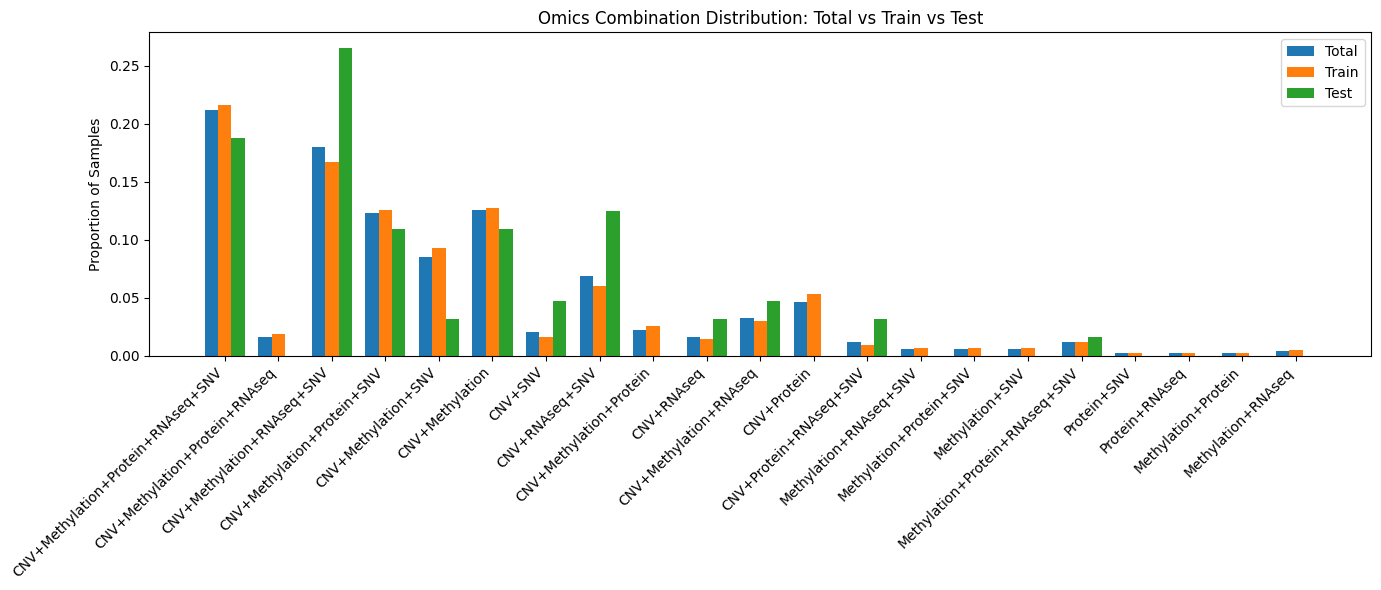

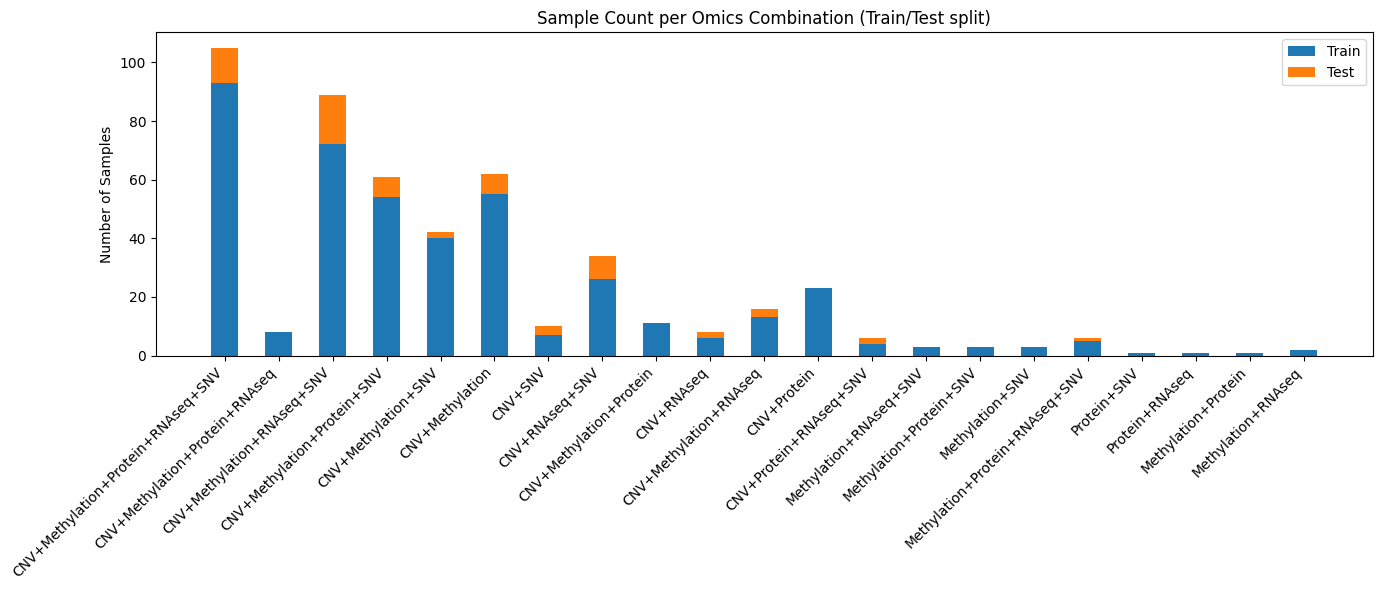

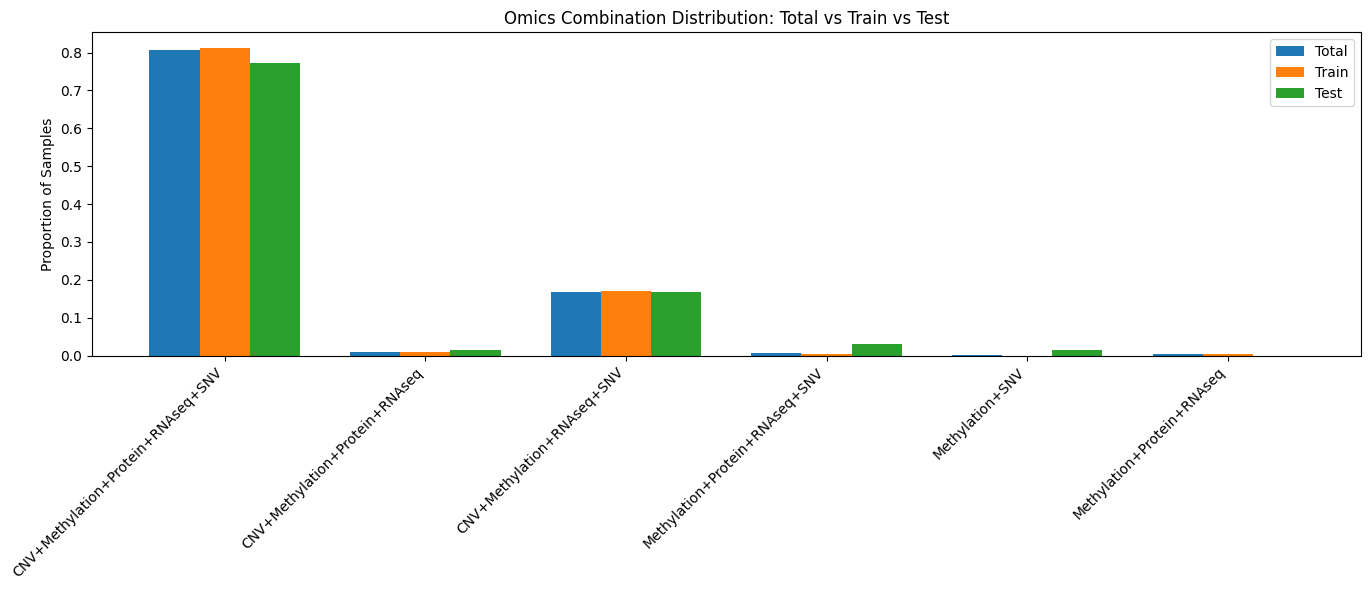

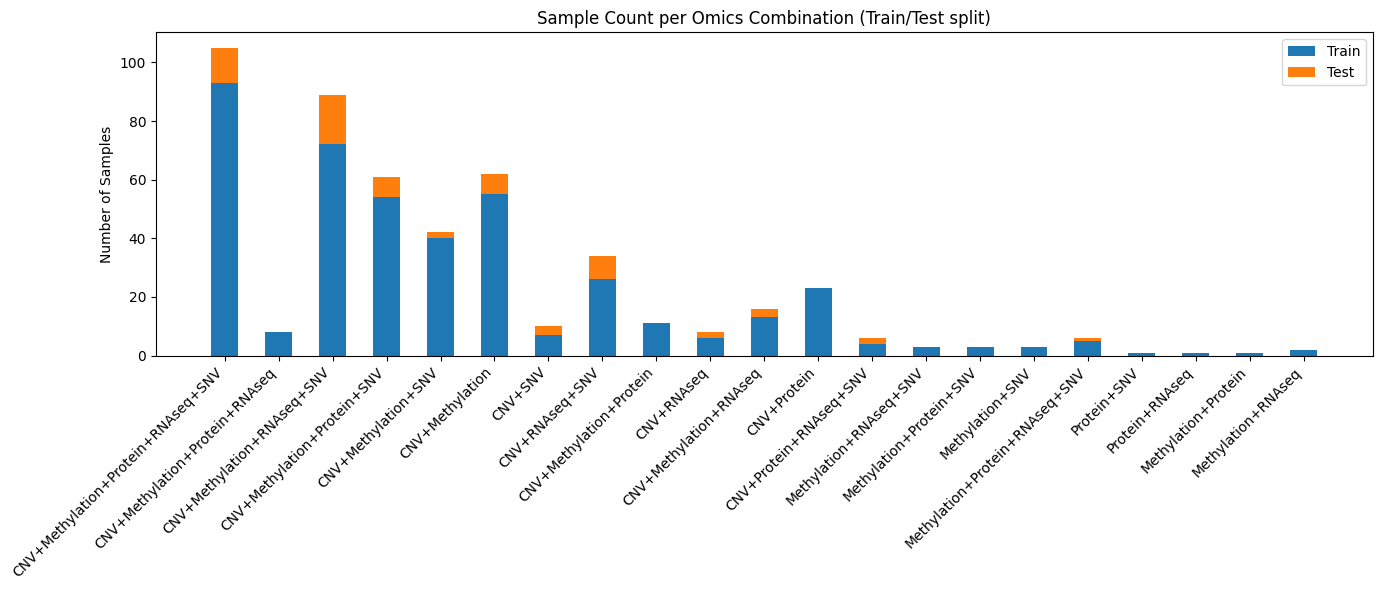

In [ ]:
# GBM
gbm_train, gbm_test, gbm_kl = find_center_split_fixed_sample_ratio_with_tolerance(
    filtered_GBM_omics,
    GMB_center_tss_sample,
    GBM_omics_combinations,
    target_ratio=0.1,
    tolerance=0.03,
    num_trials=1000,
    seed=42
)
gbm_ratios = plot_train_test_distribution_by_omics_combo(
    gbm_train,
    gbm_test,
    filtered_GBM_omics,
    GMB_center_tss_sample,
    GBM_omics_combinations
)

gbm_ratios = plot_train_test_stacked_counts_by_omics_combo(
    gbm_train,
    gbm_test,
    filtered_GBM_omics,
    GMB_center_tss_sample,
    GBM_omics_combinations
)

# LGG
lgg_train, lgg_test, lgg_kl = find_center_split_fixed_sample_ratio_with_tolerance(
    filtered_LGG_omics,
    LGG_center_tss_sample,
    LGG_omics_combinations,
    target_ratio=0.1,
    tolerance=0.03,
    num_trials=1000,
    seed=42
)

lgg_ratios = plot_train_test_distribution_by_omics_combo(
    lgg_train,
    lgg_test,
    filtered_LGG_omics,
    LGG_center_tss_sample,
    LGG_omics_combinations
)

gbm_ratios = plot_train_test_stacked_counts_by_omics_combo(
    gbm_train,
    gbm_test,
    filtered_GBM_omics,
    GMB_center_tss_sample,
    GBM_omics_combinations
)

In [ ]:
print('GBM train sample :', gbm_train)
print('GBM test sample :', gbm_test)
print('LGG train sample :', lgg_train)
print('LGG test sample :', lgg_test)

GBM train sample : ['32', 'RR', '28', '26', '27', '87', '08', '74', '19', '76', '81', '14', '15', '4W', '16', '02', '06']
GBM test sample : ['41', '12', 'OX']
LGG train sample : ['R8', 'WY', 'HW', 'KT', 'TM', 'F6', 'FN', 'VW', 'VV', 'DH', 'W9', 'E1', 'P5', 'DB', 'EZ', 'HT', 'IK', 'CS', 'DU', 'WH', 'QH', 'S9', 'RY']
LGG test sample : ['FG', 'TQ', 'VM']


In [ ]:
GBM_train_set = []
GBM_external_test_set = []
LGG_train_set = []
LGG_external_test_set = []


for k, v in GMB_center_tss_sample.items():
  if k in gbm_train:
    GBM_train_set += v
  else:
    GBM_external_test_set += v

for k, v in LGG_center_tss_sample.items():
  if k in lgg_train:
    LGG_train_set += v
  else:
    LGG_external_test_set += v

In [ ]:
print('GBM train sample :', len(GBM_train_set))
print('GBM external test sample :', len(GBM_external_test_set))
print('LGG train sample :', len(LGG_train_set))
print('LGG external test sample :', len(LGG_external_test_set))

GBM train sample : 431
GBM external test sample : 64
LGG train sample : 449
LGG external test sample : 66


Internal dataset

In [ ]:
def split_data(samples, seed=42):
    """
    Randomly split data into train, validation, and test (70:15:15 ratio).

    Parameters:
        samples (list): List of sample IDs
        seed (int): Random seed for reproducibility

    Returns:
        train_samples, val_samples, test_samples (lists)
    """
    random.seed(seed)
    samples_shuffled = samples.copy()
    random.shuffle(samples_shuffled)

    n = len(samples)
    n_train = int(n * 0.7)
    n_val = int(n * 0.15)
    n_test = n - n_train - n_val

    train = samples_shuffled[:n_train]
    val = samples_shuffled[n_train:n_train + n_val]
    test = samples_shuffled[n_train + n_val:]

    return train, val, test

In [ ]:
GBM_train_data_set = []
GBM_internla_test_data_set = []
GBM_validation_data_set = []
LGG_train_data_set = []
LGG_internla_test_data_set = []
LGG_validation_data_set = []

for omics_combi, samples in zip(GBM_omics_combinations['Omics Combination'], GBM_omics_combinations['Sample IDs']):
  sample_in_train = [sample for sample in samples if sample in GBM_train_set]
  train_data, validation_data, test_data = split_data(sample_in_train)
  GBM_train_data_set += train_data
  GBM_internla_test_data_set += test_data
  GBM_validation_data_set += validation_data

for omics_combi, samples in zip(LGG_omics_combinations['Omics Combination'], LGG_omics_combinations['Sample IDs']):
  sample_in_train = [sample for sample in samples if sample in LGG_train_set]
  train_data, validation_data, test_data = split_data(sample_in_train)
  LGG_train_data_set += train_data
  LGG_internla_test_data_set += test_data
  LGG_validation_data_set += validation_data

In [ ]:
GBM_data_split_result = {
    'Train': GBM_train_data_set,
    'Validation': GBM_validation_data_set,
    'External Test': GBM_external_test_set,
    'Internal Test': GBM_internla_test_data_set
}

LGG_data_split_result = {
    'Train': LGG_train_data_set,
    'Validation': LGG_validation_data_set,
    'External Test': LGG_external_test_set,
    'Internal Test': LGG_internla_test_data_set
}

In [ ]:
def plot_omics_combination_stacked_counts(
    omics_comb_df,
    train_samples,
    val_samples,
    external_test_samples,
    internal_test_samples
):
    """
    Create a stacked bar plot showing the number of samples per omics combination,
    separated by data splits (Train, Validation, External Test, Internal Test).

    Parameters:
        omics_comb_df (pd.DataFrame): A DataFrame with columns:
            - 'Omics Combination' (str): the combination label (e.g. 'RNA+Methylation')
            - 'Sample IDs' (list): list of sample IDs associated with that combination
        train_samples (list): List of sample IDs in the training set
        val_samples (list): List of sample IDs in the validation set
        external_test_samples (list): List of sample IDs in the external test set
        internal_test_samples (list): List of sample IDs in the internal test set
    """

    # Step 1: Organize split sample sets for quick lookup
    split_dict = {
        'Train': set(train_samples),
        'Validation': set(val_samples),
        'External Test': set(external_test_samples),
        'Internal Test': set(internal_test_samples)
    }

    # Step 2: Count the number of samples for each split per omics combination
    count_data = defaultdict(lambda: defaultdict(int))  # combo → split → count

    for _, row in omics_comb_df.iterrows():
        combo = row['Omics Combination']
        samples = row['Sample IDs']
        for s in samples:
            for split_name, split_set in split_dict.items():
                if s in split_set:
                    count_data[combo][split_name] += 1
                    break  # assume each sample appears in only one split

    # Step 3: Convert the count dictionary into a DataFrame for plotting
    combo_list = sorted(count_data.keys())
    split_list = list(split_dict.keys())

    plot_df = pd.DataFrame(index=combo_list, columns=split_list).fillna(0)
    for combo in combo_list:
        for split in split_list:
            plot_df.loc[combo, split] = count_data[combo][split]

    # Step 4: Plot the stacked bar chart
    plot_df = plot_df.astype(int)  # ensure all values are integers

    ax = plot_df.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6)
    )
    ax.set_xlabel("Omics Combination")
    ax.set_ylabel("Number of Samples")
    ax.set_title("Stacked Sample Counts per Omics Combination by Dataset Split")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title="Split")
    plt.show()

/tmp/ipython-input-34-21074847.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = pd.DataFrame(index=combo_list, columns=split_list).fillna(0)


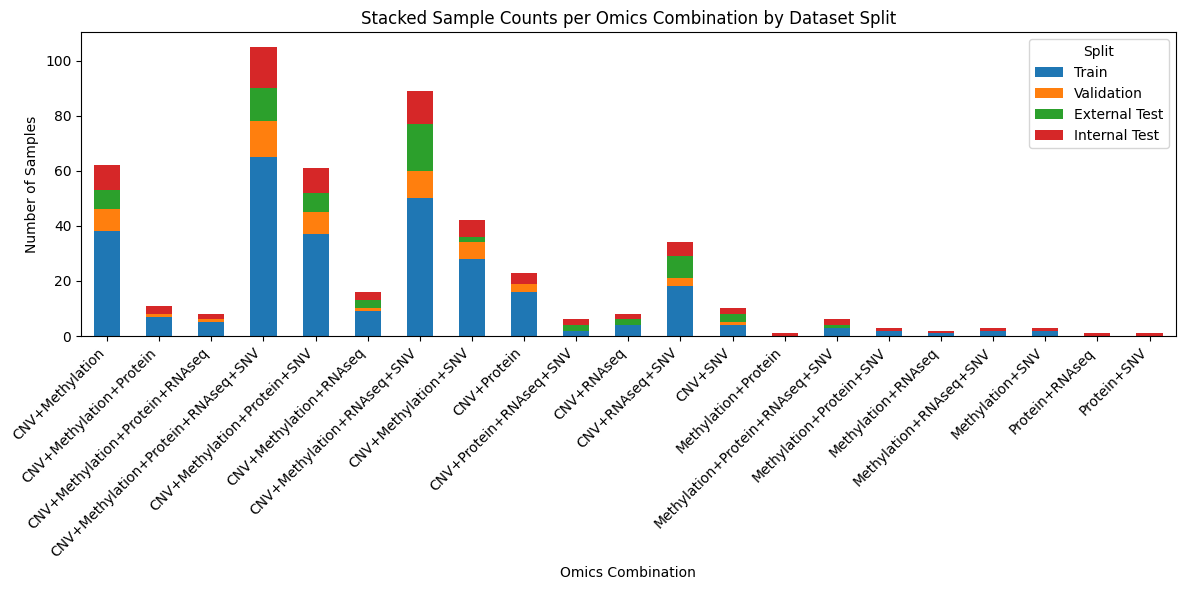

In [ ]:
plot_omics_combination_stacked_counts(
    GBM_omics_combinations,
    GBM_train_data_set,
    GBM_validation_data_set,
    GBM_external_test_set,
    GBM_internla_test_data_set
)

/tmp/ipython-input-34-21074847.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = pd.DataFrame(index=combo_list, columns=split_list).fillna(0)


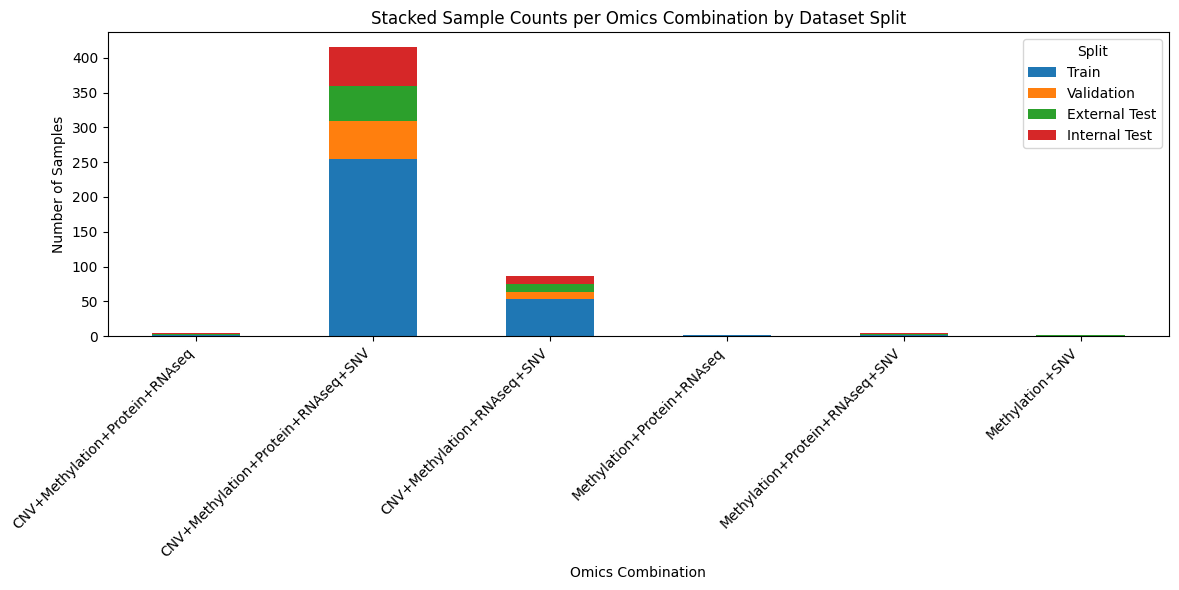

In [ ]:
plot_omics_combination_stacked_counts(
    LGG_omics_combinations,
    LGG_train_data_set,
    LGG_validation_data_set,
    LGG_external_test_set,
    LGG_internla_test_data_set
)

In [ ]:
print("GBM Data Split Counts:")
for key, value in GBM_data_split_result.items():
    print(f"{key}: {len(value)} samples")

print("\nLGG Data Split Counts:")
for key, value in LGG_data_split_result.items():
    print(f"{key}: {len(value)} samples")


GBM Data Split Counts:
Train: 293 samples
Validation: 55 samples
External Test: 64 samples
Internal Test: 83 samples

LGG Data Split Counts:
Train: 312 samples
Validation: 65 samples
External Test: 66 samples
Internal Test: 72 samples


In [ ]:
with open(Ds_project_folder_path + data_spliting_path + GBM_data_split_result_name, 'wb') as f:
    pickle.dump(GBM_data_split_result, f, pickle.HIGHEST_PROTOCOL)
with open(Ds_project_folder_path + data_spliting_path + LGG_data_split_result_name, 'wb') as f:
    pickle.dump(LGG_data_split_result, f, pickle.HIGHEST_PROTOCOL)